## Applying Predictive Linear Models to Police Shootings.

The Washington post has a collection of police shootings from 2015 to present (found here: https://github.com/washingtonpost/data-police-shootings/blob/master/fatal-police-shootings-data.csv ). The data is very comprehensive, and the dataset itself is fairly clean. There is some treating to be done to clear out some of the NaN values, but otherwise this is a good dataset. 

This notebook will be broken down into four parts. We will start with treating the data. Afterwards we will break the data up into the train/validation/test, as well as define our targets and features. Then we will fit a few different models to the data and see what performs best. And finally, we will build some visualizations that can hopefully be used to explain our findings a bit more. 

In [24]:
#Load in the data:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
DATA_PATH = '../data/'
df = pd.read_csv(DATA_PATH+'/fatal-police-shootings-data.csv')
print(df.shape)
df.head()

(5408, 14)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


### Section 1- Data Wrangling

The data in this section is pretty clean. Aside from a fair amount of NaN values scattered throughout the structure, there isn't a lot of noise here. 

In [87]:
#Choose your target. For this, I want to see if I can predict Race.
target = 'race'
print(df['race'].value_counts())
print(df['race'].isnull().sum())
df['race']
#This will be a Classification, there are 6 different races listed. 
#Baseline accuracy. White is the most common race, so its the baseline. 45.73% 
(2473 / 4890) * 100

W    2473
B    1296
H     902
A      93
N      78
O      48
Name: race, dtype: int64
518


50.57259713701432

In [21]:
def wrangle(X):
    X=X.copy()
    X['date'] = pd.to_datetime(X['date'], infer_datetime_format=True)
    cols_with_nans = ['armed','gender','flee']
    cols_for_age = ['age']
    for cols in cols_with_nans:
        X[cols] = X[cols].replace(np.nan, 'Unknown')
    mean = X['age'].dropna().sum() / len(X['age'])
    X['age'] = X['age'].replace(np.nan, mean)
    return X
wrangled = wrangle(df)

In [22]:
#I am not going to do any imputing into the race column, given that is our Target for these models.
#To avoid tainting the models, I will be dropping these rows and running from there.
wrangled.isnull().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                        0
age                          0
gender                       0
race                       518
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                         0
body_camera                  0
dtype: int64

In [23]:
print(wrangled.shape)
wrangled = wrangled.dropna()
wrangled.shape

(5408, 14)


(4890, 14)

## Section 2- Features and Targets

In my original exploration of this data, I tried to develop a few different features. However, while this was time consuming and illuminating, it also caused a great deal of leakage to enter the data. Without those engineered features, we only have 10 columns, but those will work for the model that we're creating here.

In [26]:
target = 'race'
columns_to_drop = ['id', 'name', 'date', 'race']
base, test = train_test_split(wrangled, test_size=.15, random_state=1)
train, val = train_test_split(base, test_size=.2, random_state=1)
train.shape, val.shape, test.shape

((3324, 14), (832, 14), (734, 14))

In [27]:
X_train = train.drop(columns=columns_to_drop, axis=1)
y_train = train[target]
X_val = val.drop(columns=columns_to_drop, axis=1)
y_val = val[target]
X_test = test.drop(columns=columns_to_drop, axis=1)
y_test = test[target]
X_train.shape, y_train.shape

((3324, 10), (3324,))

## Section 3- Selecting and Fitting the Models

This is a classification problem (as there are 6 racial demographics to pick from), and I will need two models to build around. I am going to select Logistic Regression for my linear model. And I will be going with XGBClassifier for my tree-based model. This will give me a wide range of answers and wide variety of visualizations to select from. For logistic regression, I'll be going with a pipeline, but for XGB I will be doing it manually since Shap doesn't like pipelines much.

In [71]:
log_pipeline = make_pipeline(ce.OrdinalEncoder(),
                             SimpleImputer(),
                            LogisticRegression(max_iter=200))
log_pipeline.fit(X_train, y_train);
print('Train Accuracy:', log_pipeline.score(X_train, y_train))
print('Validation Accuracy:', log_pipeline.score(X_val, y_val))

Train Accuracy: 0.5324909747292419
Validation Accuracy: 0.5324519230769231


Logistic Regression beats the baseline without much tinkering, so that's solid. Now we're move on to XGB.

In [72]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [92]:
xgb = XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1)
xgb.fit(X_train_encoded, y_train)
print('Train Accuracy:', xgb.score(X_train_encoded, y_train))
print('Validation Accuracy:', xgb.score(X_val_encoded, y_val))
print('Test Accuracy:', xgb.score(X_test_encoded, y_test))

Train Accuracy: 0.644705174488568
Validation Accuracy: 0.5444711538461539
Test Accuracy: 0.5422343324250681


XGB also beats the baseline without too much engineering. I wouldn't say that either of these models does its job particularly well, but they illustrate the points sufficiently.

## Section 4- Visualizations

For the build week, I will need 6 visualizations of the data. I will be doing the following:

1- Distribution

2- A Confusion Matrix for the Logistic Regression

3- Permutation Importances for the Logistic Regression

4- Partial Dependence Plot, 1 feature for XGB

5- Partial Dependence Plot, 2 features for XGB

6- Shapley Values for a randomly selected XGB row.

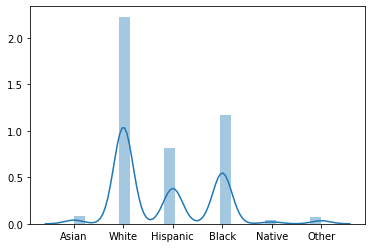

In [45]:
#Distribution Plot
import seaborn as sns
y = df['race'].dropna()
encode_it = ce.OrdinalEncoder()
y_encoded = encode_it.fit_transform(y)
g = sns.distplot(y_encoded);
g.set(xticklabels= ['1','Asian','White','Hispanic','Black','Native','Other']);

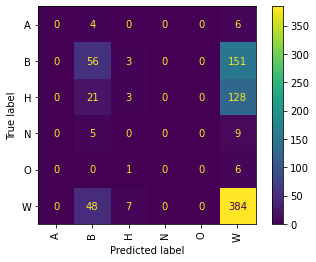

In [46]:
#Confusion Matrix
plot_confusion_matrix(log_pipeline, X_val, y_val, values_format='.0f',
                     xticks_rotation='vertical');

In [52]:
#Permutation Importances
pi = permutation_importance(xgb, X_val_encoded, y_val, random_state=1, n_jobs=-1)
pi.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [53]:
p_importance = pd.DataFrame({'feature': X_val.columns,
                            'weight': pi.importances_mean,
                            'std': pi.importances_mean})
p_importance.sort_values('weight', ascending=False).head(10)

,feature,weight,std
5,state,0.094231,0.094231
2,age,0.033173,0.033173
9,body_camera,0.004808,0.004808
3,gender,0.004808,0.004808
6,signs_of_mental_illness,0.003365,0.003365
7,threat_level,0.001202,0.001202
1,armed,-0.000481,-0.000481
0,manner_of_death,-0.000721,-0.000721
8,flee,-0.003606,-0.003606
4,city,-0.018029,-0.018029


In [93]:
import eli5
from eli5.sklearn import PermutationImportance
feature_names = X_val.columns.tolist()
permuter = PermutationImportance(xgb, scoring='accuracy',
                                n_iter=5, random_state=1)
permuter.fit(X_val_encoded, y_val)
eli5.show_weights(permuter, top=None, feature_names=feature_names)


Weight,Feature
0.0899 ± 0.0379,state
0.0286 ± 0.0230,age
0.0103 ± 0.0215,signs_of_mental_illness
0.0048 ± 0.0043,body_camera
0.0046 ± 0.0028,gender
0.0038 ± 0.0132,armed
0.0007 ± 0.0054,threat_level
-0.0002 ± 0.0024,manner_of_death
-0.0053 ± 0.0075,flee
-0.0216 ± 0.0199,city


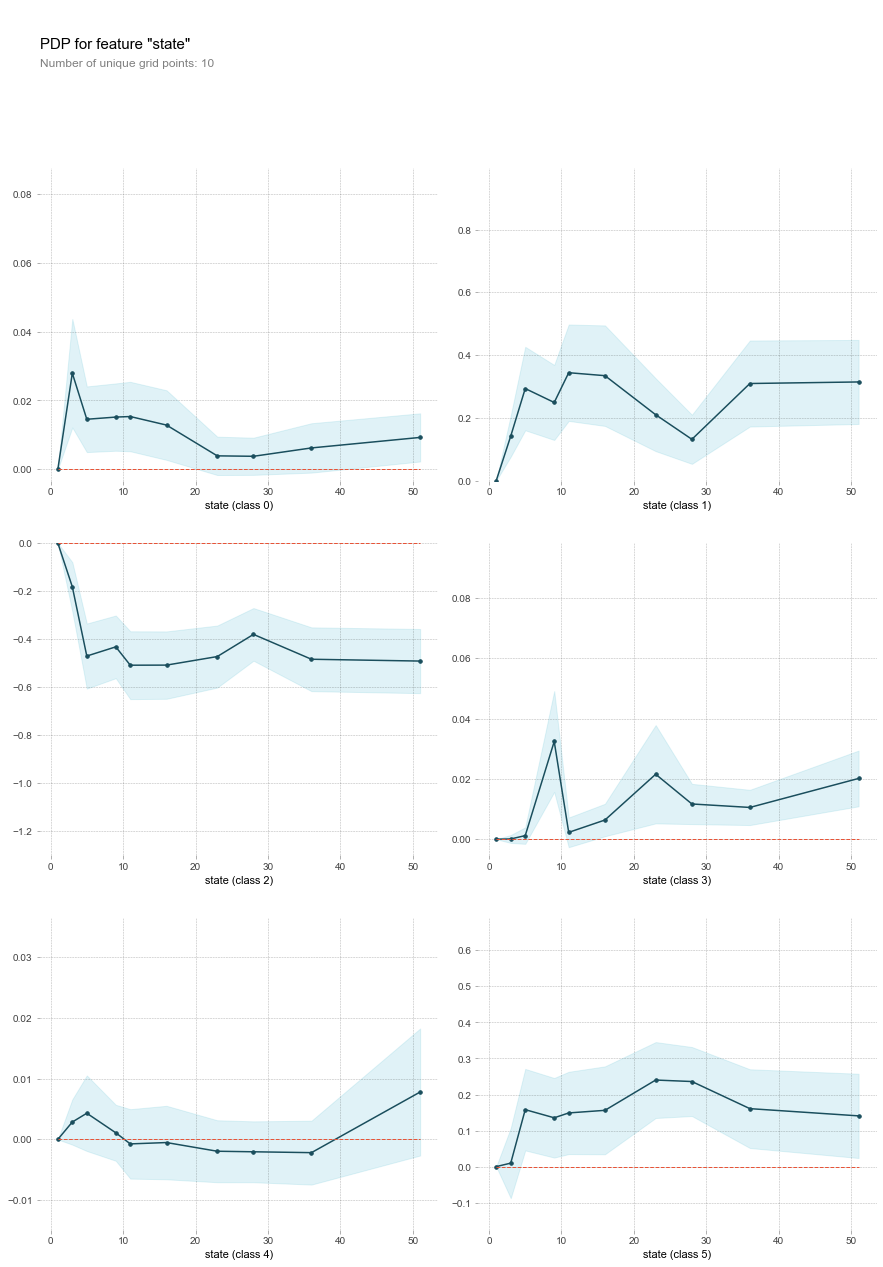

In [50]:
#PDP, 1 Feature
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'state'
features = X_train.columns
pdp_dist = pdp.pdp_isolate(model=xgb, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

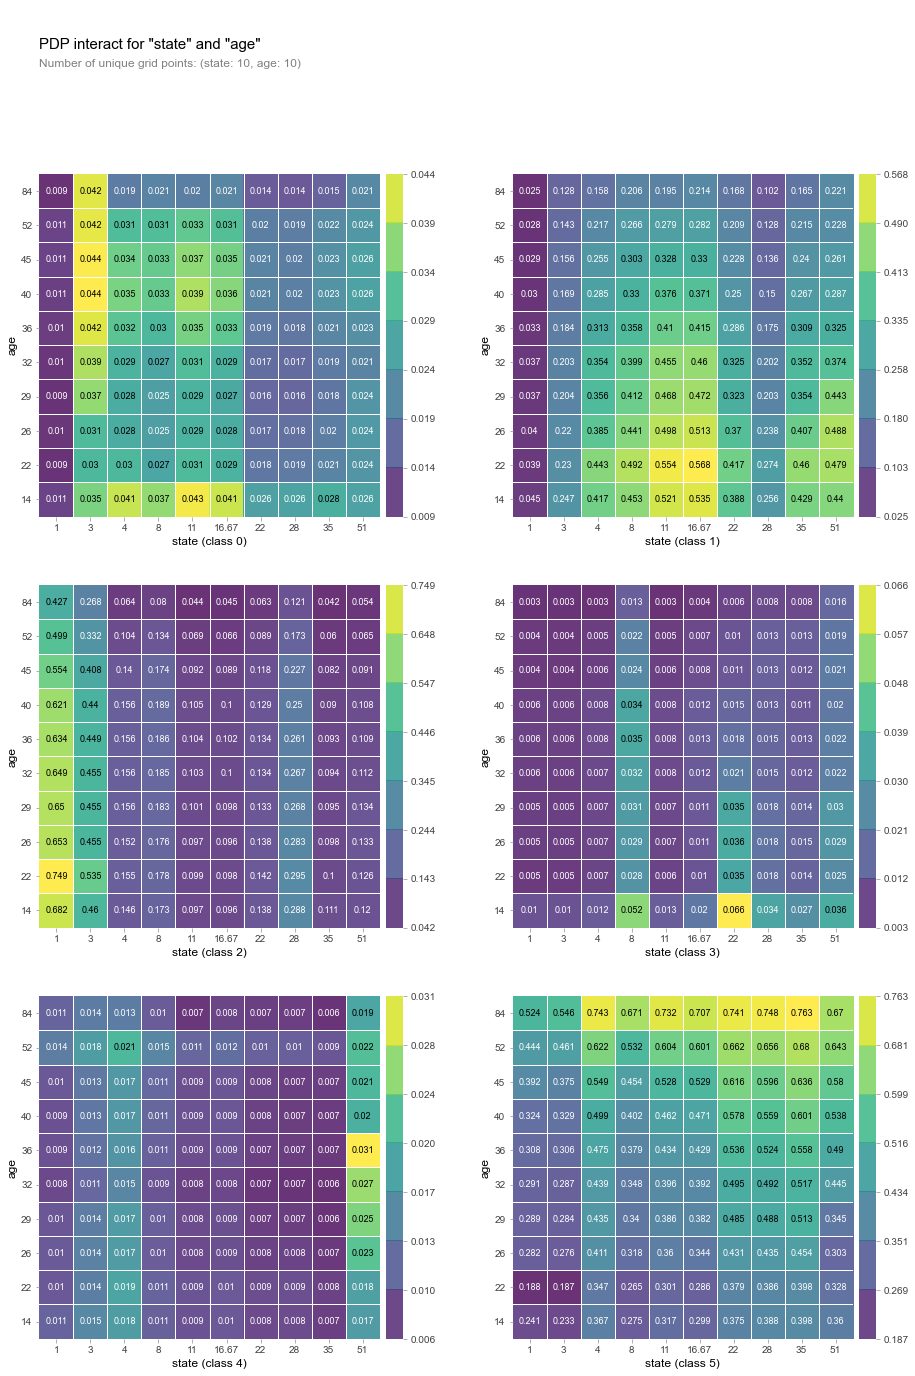

In [64]:
#PDP, 2 Features
features = ['state', 'age']
interaction = pdp_interact(model=xgb,
                          dataset=X_val_encoded,
                          model_features=X_val_encoded.columns,
                          features=features)
pdp_interact_plot(interaction, plot_type='grid',feature_names=features);

In [84]:
model = XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_train_processed, y_train)

XGBClassifier(n_jobs=-1, objective='multi:softprob', random_state=1)

In [85]:
import shap
row= X_test.iloc[[50]]
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(base_value=explainer.expected_value[0],
                shap_values=shap_values[0],
                features=row,
                link='logit')

In [121]:
to_drop = ['id','name','date','armed','city','manner_of_death']
wrangled1 = wrangled.drop(columns=to_drop)
wrangled1.to_csv('wrangled1.csv')

In [122]:
wrangled1.head()

,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera
0,53.0,M,A,WA,True,attack,Not fleeing,False
1,47.0,M,W,OR,False,attack,Not fleeing,False
2,23.0,M,H,KS,False,other,Not fleeing,False
3,32.0,M,W,CA,True,attack,Not fleeing,False
4,39.0,M,H,CO,False,attack,Not fleeing,False


In [128]:
import plotly.express as px
fig = px.violin(wrangled1, y='race', x='age', color='race', box=True, points='all', hover_data=wrangled1.columns)
fig.show()

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
